# Investigation of Station Data from Bay Area Bike Share Published Data

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 10

# Utility Functions

In [3]:
def zip_to_landmark(zip_code):
    ''' Return zipcode for given landmark'''
    if zip_code == 94107:
        return 'San Francisco'
    if zip_code == 94063:
        return 'Redwood City'
    if zip_code == 94301:
        return 'Palo Alto'
    if zip_code == 94041:
        return 'Mountain View'
    if zip_code == 95113:
        return 'San Jose'
    return False

In [4]:
ordered_zipcodes = [94107, 95113, 94041, 94301, 94063]

# Load Data Sets

## Pruning Filters
<p>The status data sets are massive, lets prune them on import chunks to reduce the file size we are dealing with</p>

In [5]:
commuter_stations = [69, 70]
top_terminals = [70, 69, 55, 50, 74, 61, 65, 77, 67, 52]

## Load Status Data

In [6]:
print('[%s] Loading Status Data...' % datetime.datetime.now().time())

status_df = pd.DataFrame()
status_file = '../clean_data/bayareabikeshare/status_data_cleaned.csv'
status_file = '../clean_data/bayareabikeshare/status_data_5m_resampled_cleaned.csv'


# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(status_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(status_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['time']):
    
    # prune chunk
#     chunk = chunk[chunk.station_id.isin(top_terminals)]
    chunk = chunk[chunk.zip_code == 94107]
    
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), 
                                                    str(chunk_counter).rjust(len(str(num_chunks))), 
                                                    str(num_chunks).rjust(len(str(num_chunks)))))
    chunk_counter += 1

status_df = pd.concat(chunks)

print('[%s] Complete!' % datetime.datetime.now().time())

[15:09:16.075108] Loading Status Data...
		[15:09:22.137261] finished chunk    1 of 2175
		[15:09:29.058318] finished chunk  218 of 2175
		[15:09:36.290886] finished chunk  436 of 2175
		[15:09:43.117405] finished chunk  654 of 2175
		[15:09:50.780253] finished chunk  872 of 2175
		[15:09:58.611937] finished chunk 1090 of 2175
		[15:10:07.801422] finished chunk 1308 of 2175
		[15:10:16.438686] finished chunk 1526 of 2175
		[15:10:24.524268] finished chunk 1744 of 2175
		[15:10:32.541922] finished chunk 1962 of 2175
		[15:10:40.469776] finished chunk 2175 of 2175
[15:10:41.889863] Complete!


In [7]:
status_df.reset_index(inplace=True, drop=True)
status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11015755 entries, 0 to 11015754
Data columns (total 7 columns):
station_id         int64
time               datetime64[ns]
bikes_available    float64
docks_available    float64
dock_count         float64
zip_code           float64
utilization        float64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 588.3 MB


In [8]:
status_import = status_df.copy()

In [9]:
status_df.drop(['dock_count', 'zip_code'], axis=1, inplace=True)
status_df.reset_index(inplace=True, drop=True)

status_df.set_index('time', inplace=True)

status_df.head()

,station_id,bikes_available,docks_available,utilization
time,,,,
2013-08-29 12:05:00,39,7.0,12.0,0.631579
2013-08-29 12:10:00,39,7.0,12.0,0.631579
2013-08-29 12:15:00,39,7.0,12.0,0.631579
2013-08-29 12:20:00,39,7.0,12.0,0.631579
2013-08-29 12:25:00,39,7.0,12.0,0.631579


In [10]:
station_merged = status_df.groupby(level=0).mean()
station_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315596 entries, 2013-08-29 12:05:00 to 2016-08-31 23:55:00
Data columns (total 4 columns):
station_id         315596 non-null float64
bikes_available    315596 non-null float64
docks_available    315596 non-null float64
utilization        315596 non-null float64
dtypes: float64(4)
memory usage: 12.0 MB


In [11]:
station_merged.head()

,station_id,bikes_available,docks_available,utilization
time,,,,
2013-08-29 12:05:00,59.705882,8.485294,10.279412,0.531180
2013-08-29 12:10:00,59.705882,8.360294,10.404412,0.535750
2013-08-29 12:15:00,59.705882,8.102941,10.661765,0.547113
2013-08-29 12:20:00,59.705882,8.147059,10.617647,0.545329
2013-08-29 12:25:00,59.705882,8.279412,10.485294,0.539954


In [12]:
station_merged.tail()

,station_id,bikes_available,docks_available,utilization
time,,,,
2016-08-31 23:35:00,61.972973,9.254054,10.610811,0.552924
2016-08-31 23:40:00,61.972973,9.261261,10.603604,0.552317
2016-08-31 23:45:00,61.972973,9.252252,10.612613,0.552791
2016-08-31 23:50:00,61.972973,9.270270,10.594595,0.551843
2016-08-31 23:55:00,61.972973,9.270270,10.594595,0.551843


# Persistence Forecast Model
<p><b>Naive Forecast:</b> uses current observation t to predict observation at the next time step (t+1)</p>

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
util = station_merged['utilization'].copy()

In [15]:
values = pd.DataFrame(util.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t-1', 't+1']
result = df.corr()
print(result)


          t-1       t+1
t-1  1.000000  0.986176
t+1  0.986176  1.000000


### Very strong positive coorelation between observation and lag=1 value

In [16]:
df.head(3)

,t-1,t+1
0,NaN,0.531180
1,0.53118,0.535750
2,0.53575,0.547113


In [17]:
# one week of data, from 5 minute intervals, 12 per hour, 24 per day, 7 days per week
interval = 5
predict_size = int((60/interval) * 24 * 7)

In [18]:
# predict last predict_size intervals data with all leading days
# train: all except last predict_size intervals
# test : last predict_size intervals
X = df.values
train, test = X[1:-predict_size], X[-predict_size:]

In [19]:
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

In [20]:
# persistence model
def model_persistence(x):
    return x

In [21]:
# walk forward validation
y_pred = list()

for x in X_test:
    pred = model_persistence(x)
    
    y_pred.append(pred)

In [22]:
test_score = mean_squared_error(y_test, y_pred)
print('Test MSE: {:2.4f}'.format(test_score))

Test MSE: 0.0000


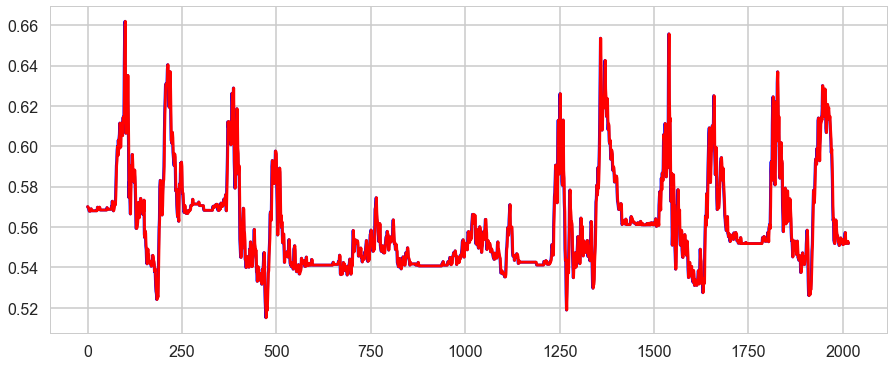

In [23]:
plt.subplots(figsize=(15,6))
plt.plot(y_test, c='b')
plt.plot(y_pred, c='r')
plt.show()

# Test on Each Station

          t-1       t+1
t-1  1.000000  0.994731
t+1  0.994731  1.000000

Test MSE: 0.0522


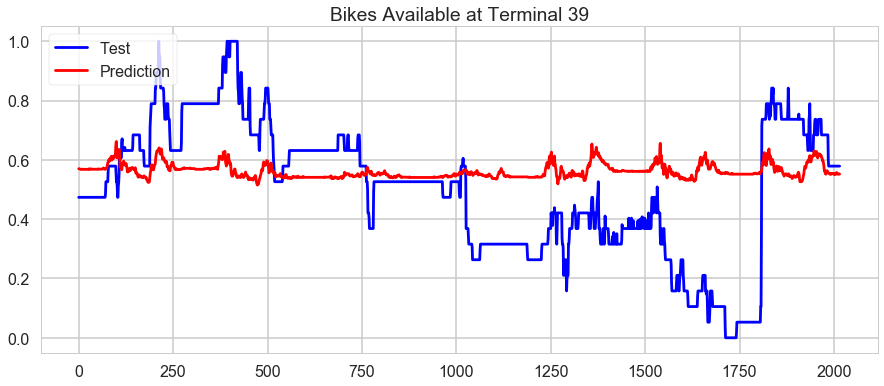

          t-1       t+1
t-1  1.000000  0.992228
t+1  0.992228  1.000000

Test MSE: 0.0571


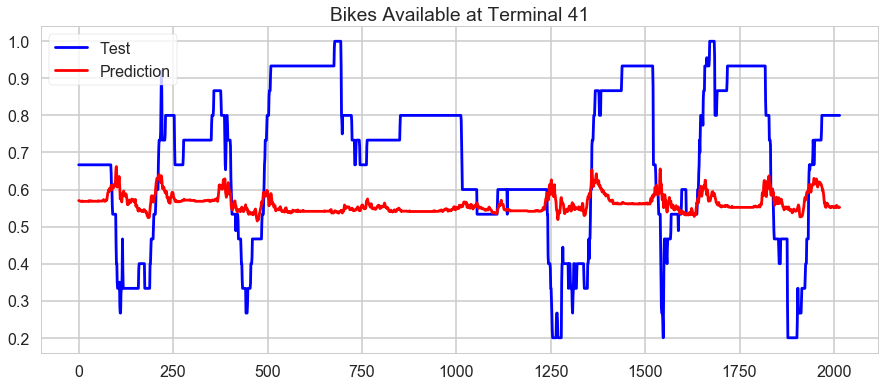

          t-1       t+1
t-1  1.000000  0.990508
t+1  0.990508  1.000000

Test MSE: 0.0130


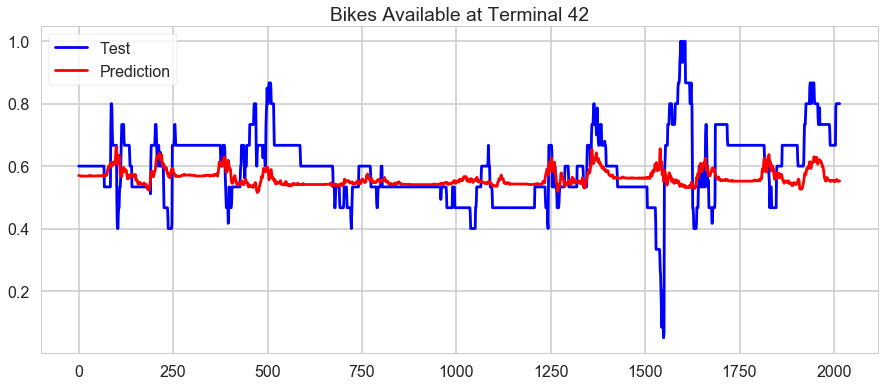

         t-1      t+1
t-1  1.00000  0.99239
t+1  0.99239  1.00000

Test MSE: 0.0723


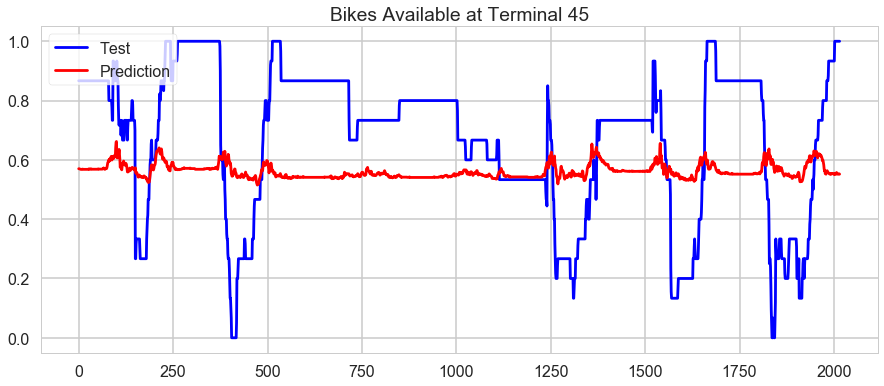

          t-1       t+1
t-1  1.000000  0.994366
t+1  0.994366  1.000000

Test MSE: 0.0485


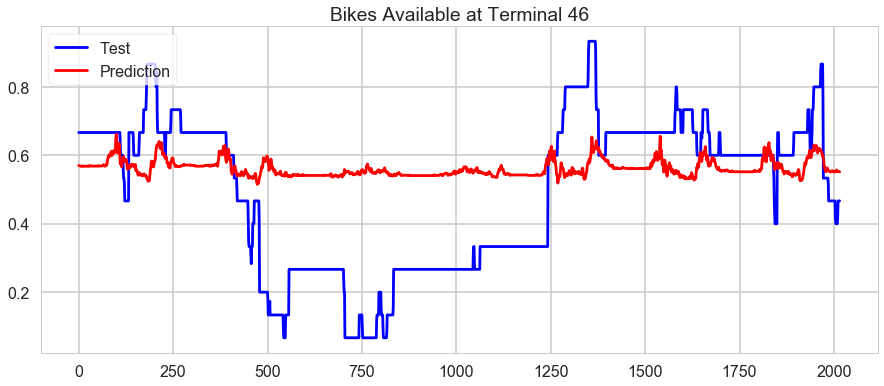

          t-1       t+1
t-1  1.000000  0.996012
t+1  0.996012  1.000000

Test MSE: 0.0264


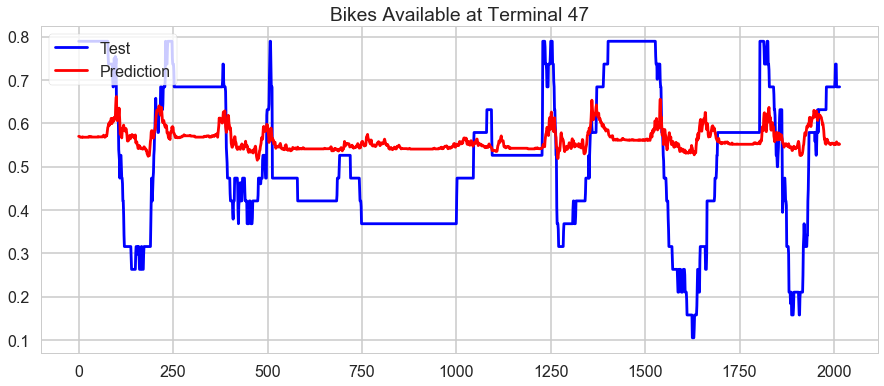

          t-1       t+1
t-1  1.000000  0.991048
t+1  0.991048  1.000000

Test MSE: 0.0538


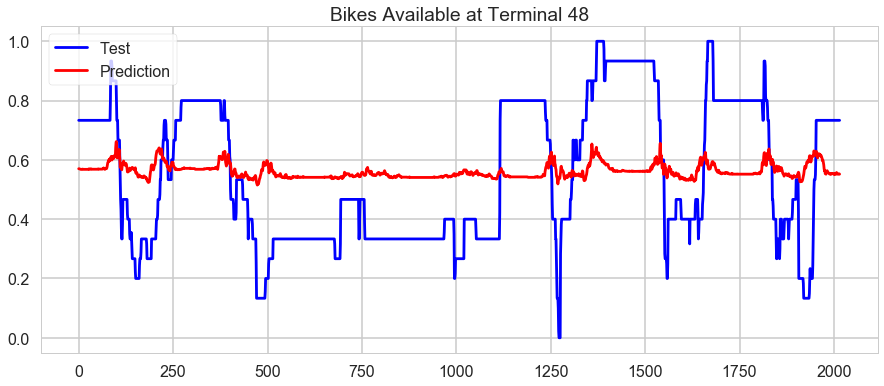

        t-1     t+1
t-1  1.0000  0.9949
t+1  0.9949  1.0000

Test MSE: 0.0315


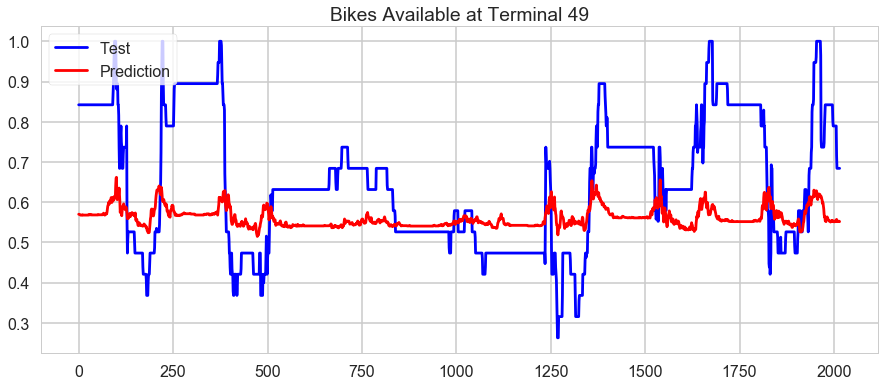

          t-1       t+1
t-1  1.000000  0.989716
t+1  0.989716  1.000000

Test MSE: 0.0990


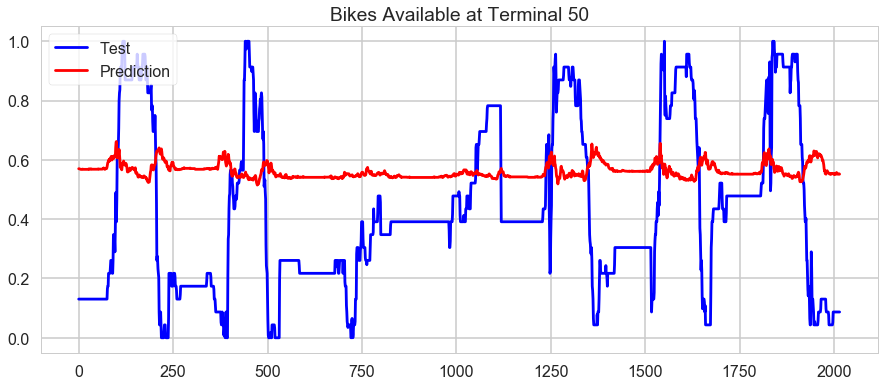

          t-1       t+1
t-1  1.000000  0.988969
t+1  0.988969  1.000000

Test MSE: 0.0571


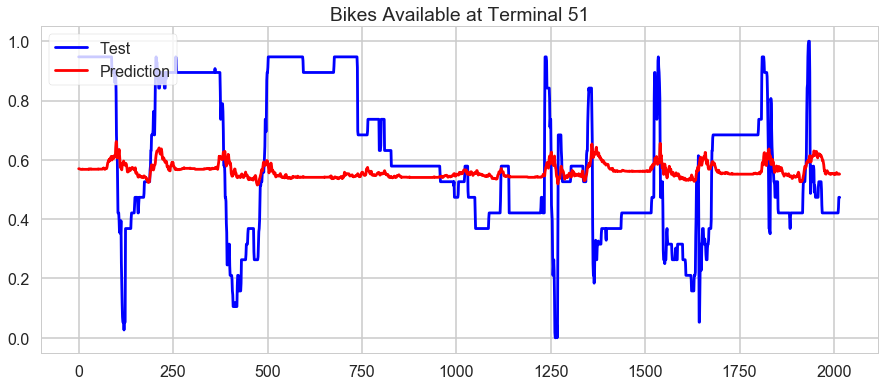

          t-1       t+1
t-1  1.000000  0.991105
t+1  0.991105  1.000000

Test MSE: 0.0574


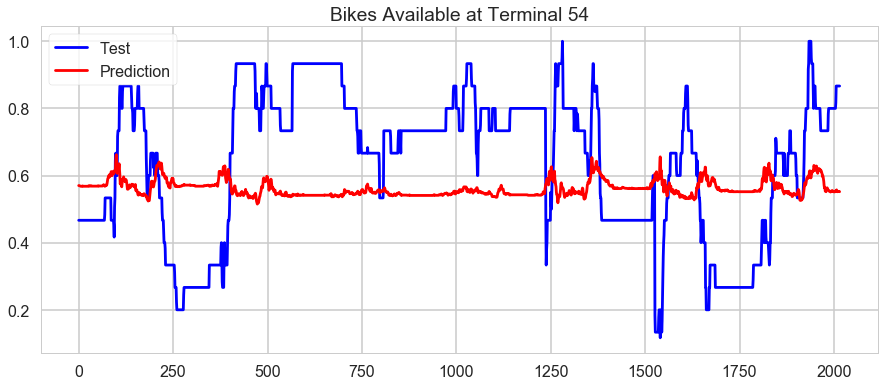

          t-1       t+1
t-1  1.000000  0.994131
t+1  0.994131  1.000000

Test MSE: 0.0818


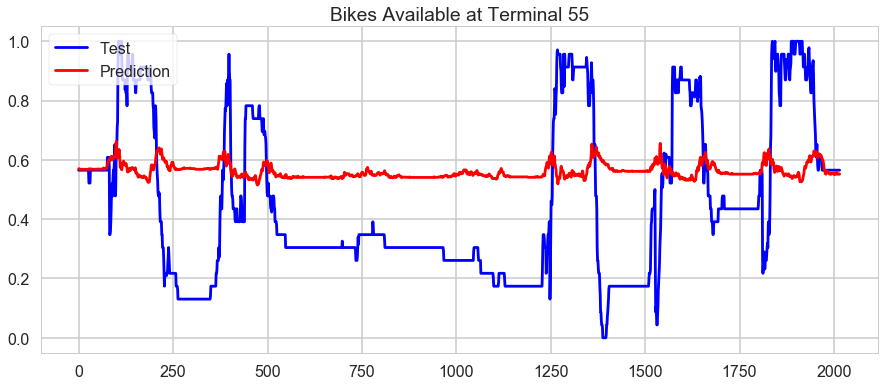

          t-1       t+1
t-1  1.000000  0.992073
t+1  0.992073  1.000000

Test MSE: 0.0444


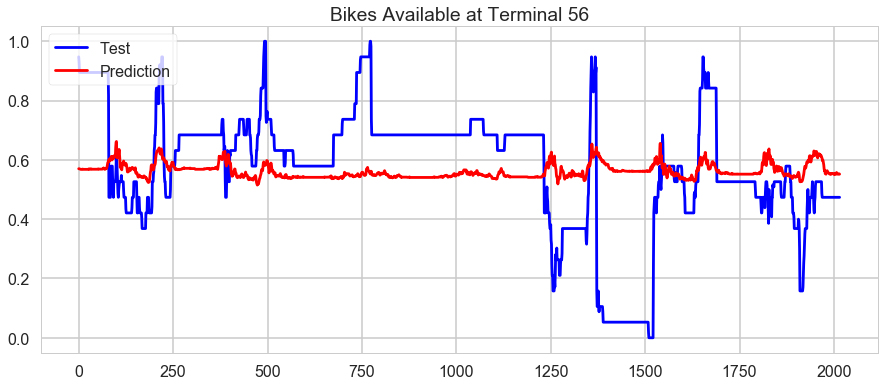

          t-1       t+1
t-1  1.000000  0.991316
t+1  0.991316  1.000000

Test MSE: 0.0342


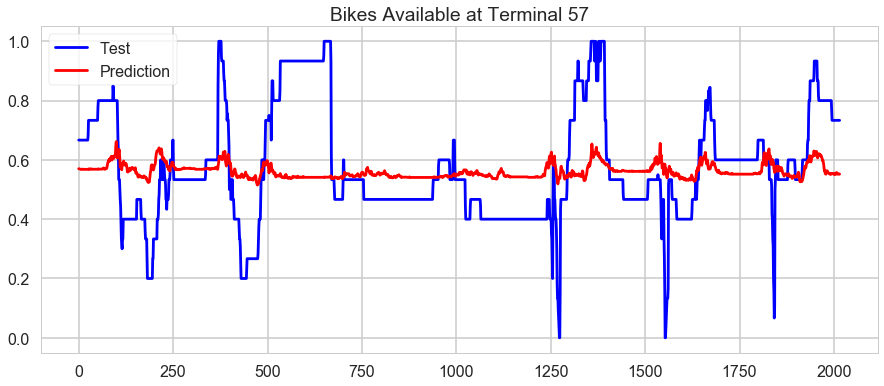

          t-1       t+1
t-1  1.000000  0.996717
t+1  0.996717  1.000000

Test MSE: 0.0340


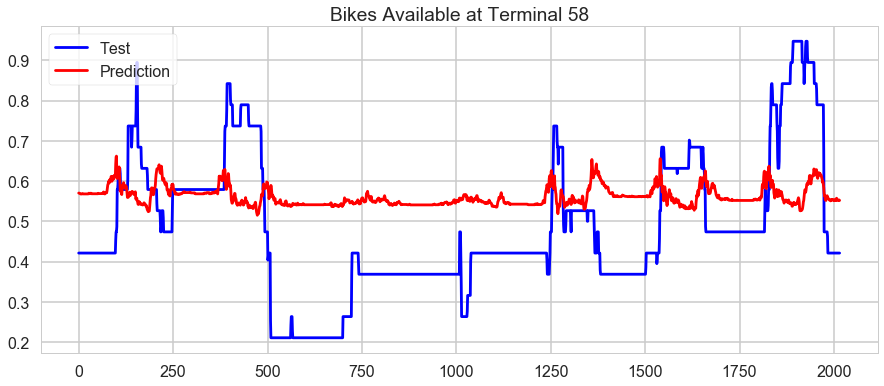

          t-1       t+1
t-1  1.000000  0.996178
t+1  0.996178  1.000000

Test MSE: 0.0243


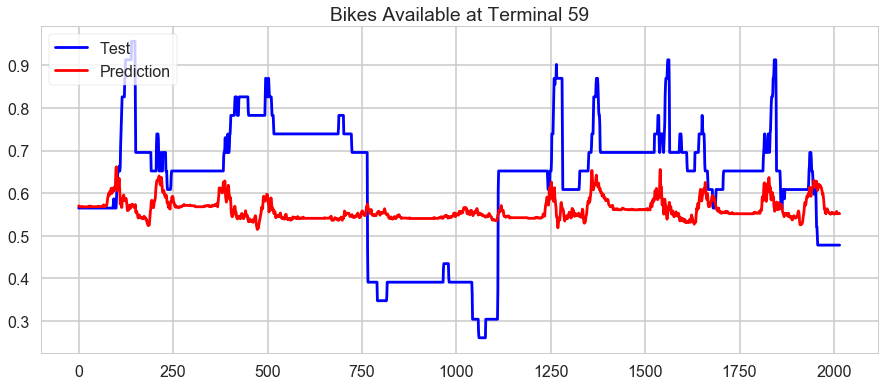

          t-1       t+1
t-1  1.000000  0.983412
t+1  0.983412  1.000000

Test MSE: 0.0391


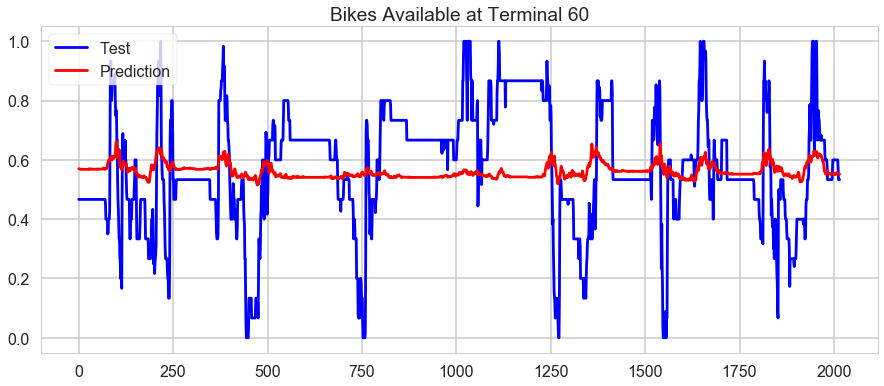

          t-1       t+1
t-1  1.000000  0.991218
t+1  0.991218  1.000000

Test MSE: 0.0834


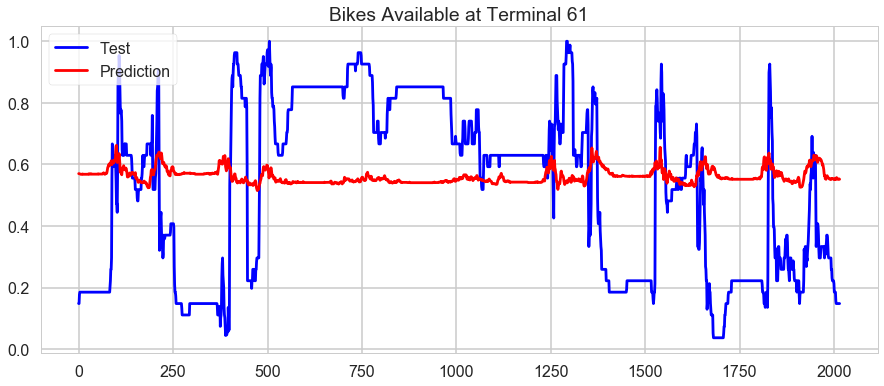

          t-1       t+1
t-1  1.000000  0.989642
t+1  0.989642  1.000000

Test MSE: 0.0766


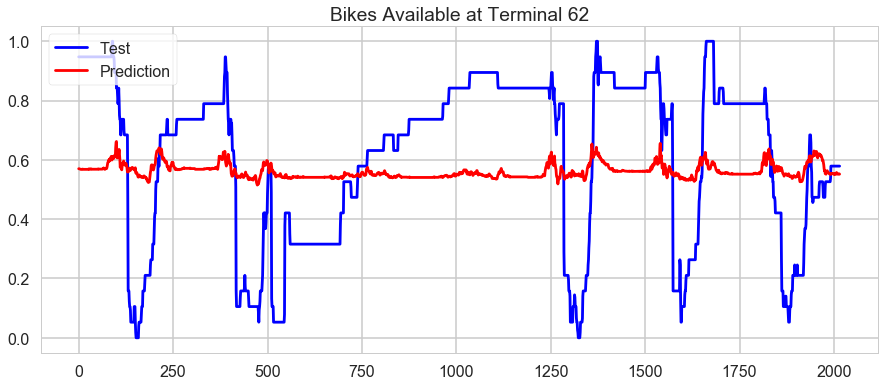

          t-1       t+1
t-1  1.000000  0.994254
t+1  0.994254  1.000000

Test MSE: 0.0631


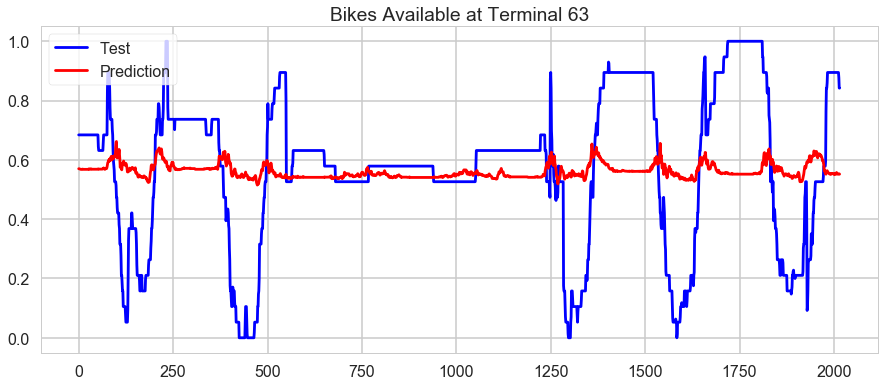

          t-1       t+1
t-1  1.000000  0.984331
t+1  0.984331  1.000000

Test MSE: 0.0578


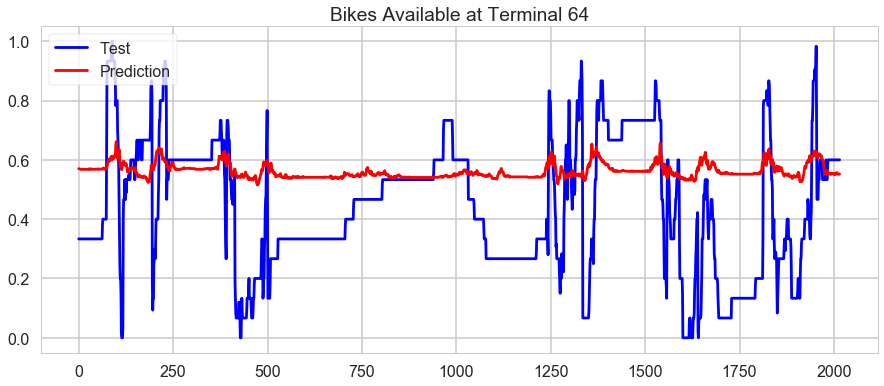

          t-1       t+1
t-1  1.000000  0.977878
t+1  0.977878  1.000000

Test MSE: 0.0627


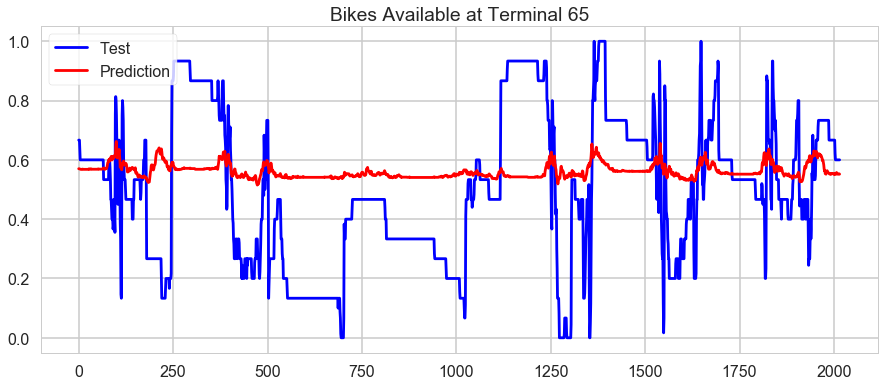

          t-1       t+1
t-1  1.000000  0.994827
t+1  0.994827  1.000000

Test MSE: 0.0180


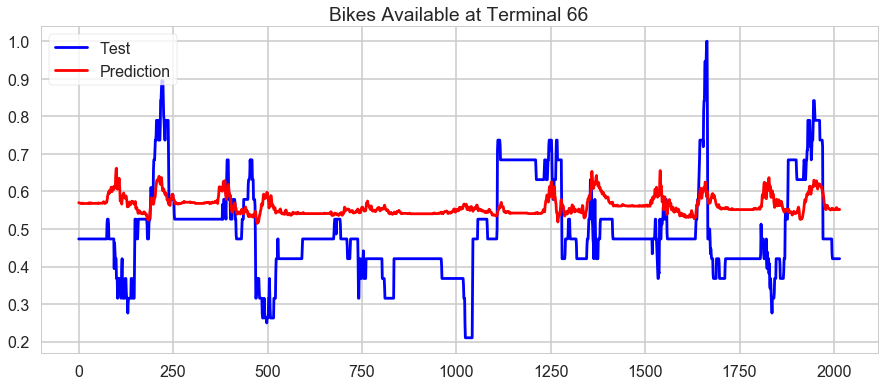

          t-1       t+1
t-1  1.000000  0.995348
t+1  0.995348  1.000000

Test MSE: 0.0259


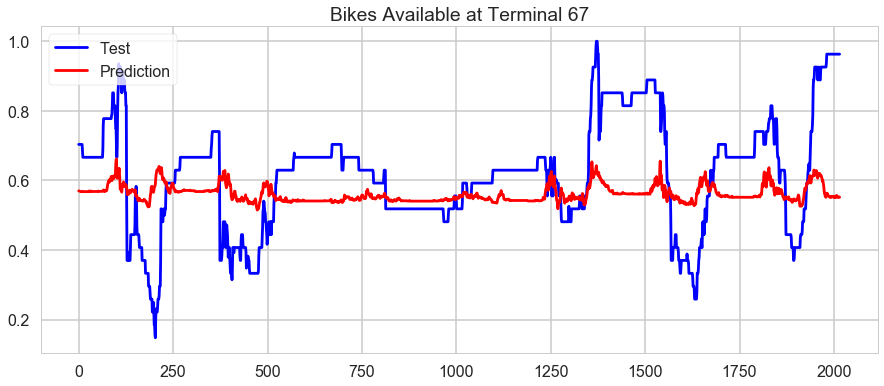

         t-1      t+1
t-1  1.00000  0.99458
t+1  0.99458  1.00000

Test MSE: 0.0485


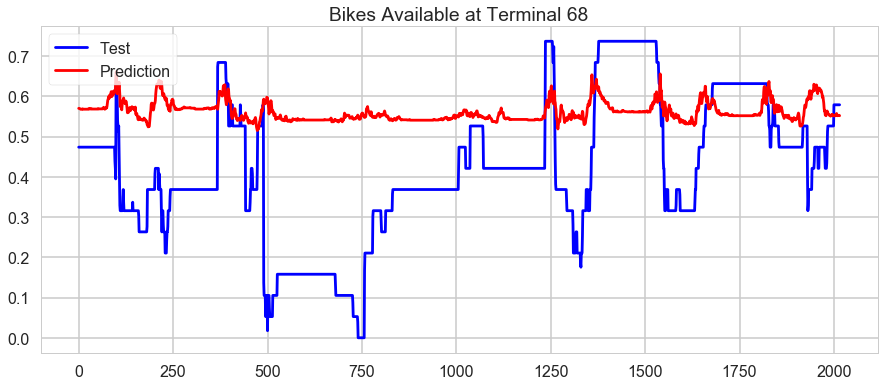

          t-1       t+1
t-1  1.000000  0.986918
t+1  0.986918  1.000000

Test MSE: 0.0993


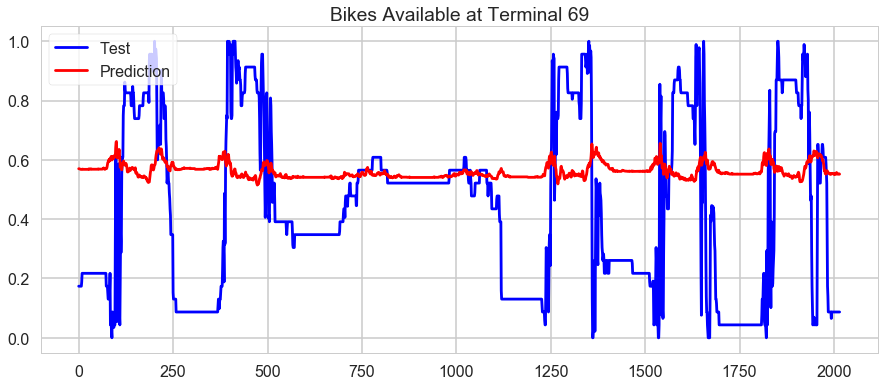

          t-1       t+1
t-1  1.000000  0.980163
t+1  0.980163  1.000000

Test MSE: 0.1408


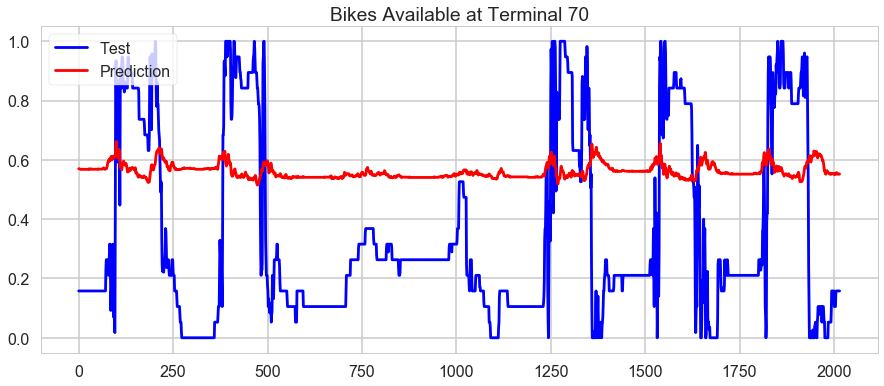

         t-1      t+1
t-1  1.00000  0.99221
t+1  0.99221  1.00000

Test MSE: 0.0572


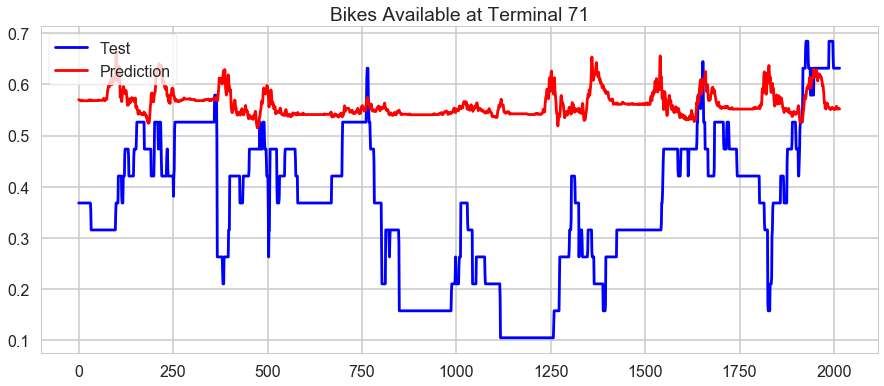

         t-1      t+1
t-1  1.00000  0.99734
t+1  0.99734  1.00000

Test MSE: 0.0588


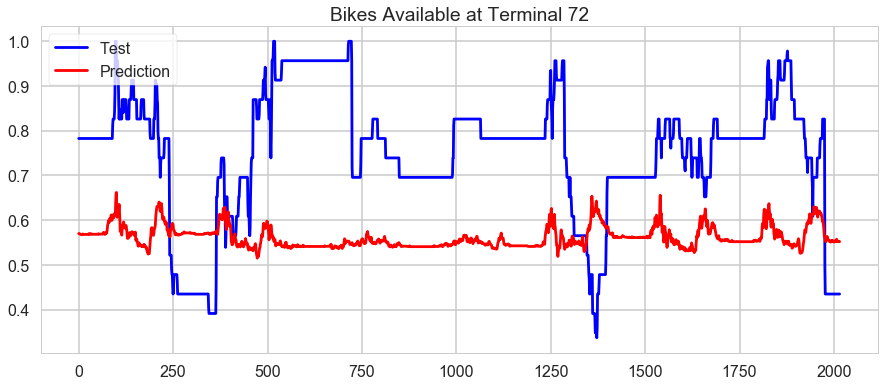

          t-1       t+1
t-1  1.000000  0.990198
t+1  0.990198  1.000000

Test MSE: 0.0860


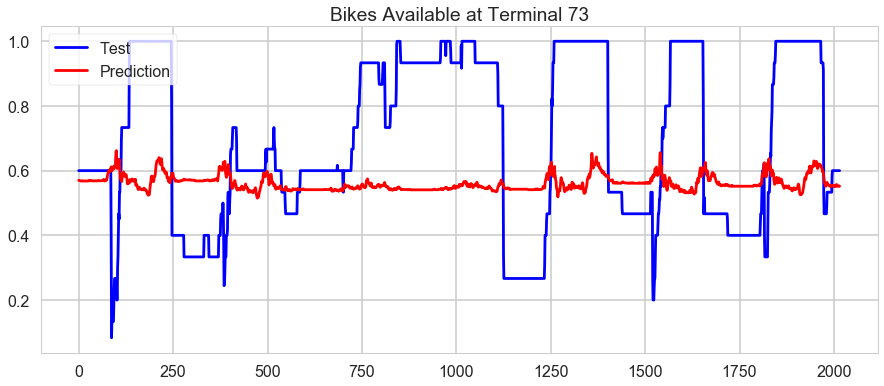

          t-1       t+1
t-1  1.000000  0.994574
t+1  0.994574  1.000000

Test MSE: 0.0869


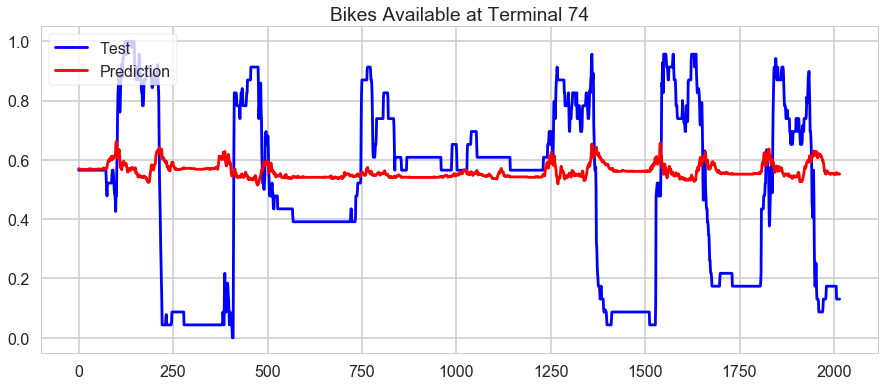

          t-1       t+1
t-1  1.000000  0.995588
t+1  0.995588  1.000000

Test MSE: 0.0685


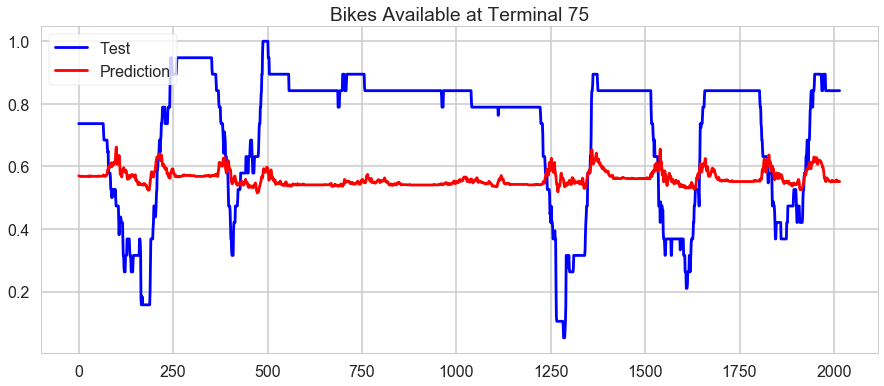

          t-1       t+1
t-1  1.000000  0.993707
t+1  0.993707  1.000000

Test MSE: 0.0565


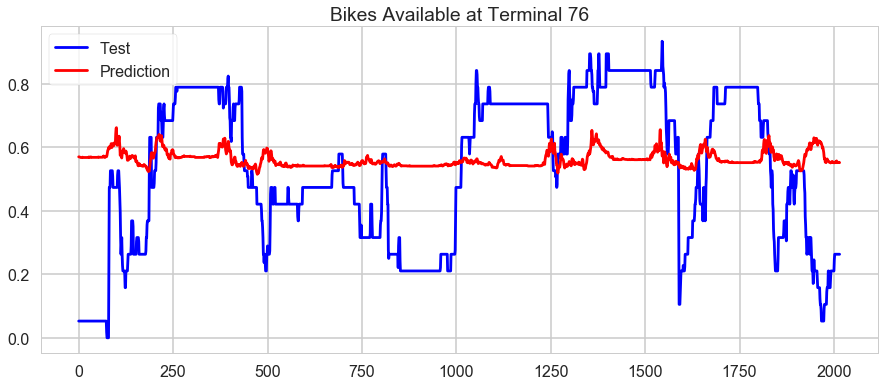

        t-1     t+1
t-1  1.0000  0.9938
t+1  0.9938  1.0000

Test MSE: 0.0216


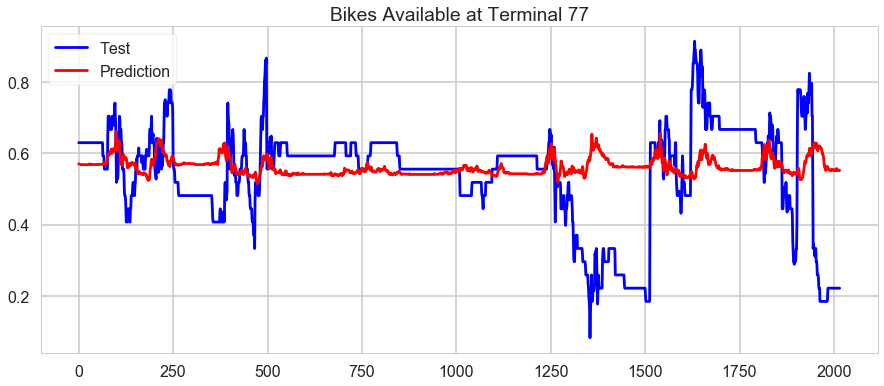

          t-1       t+1
t-1  1.000000  0.989225
t+1  0.989225  1.000000

Test MSE: 0.0629


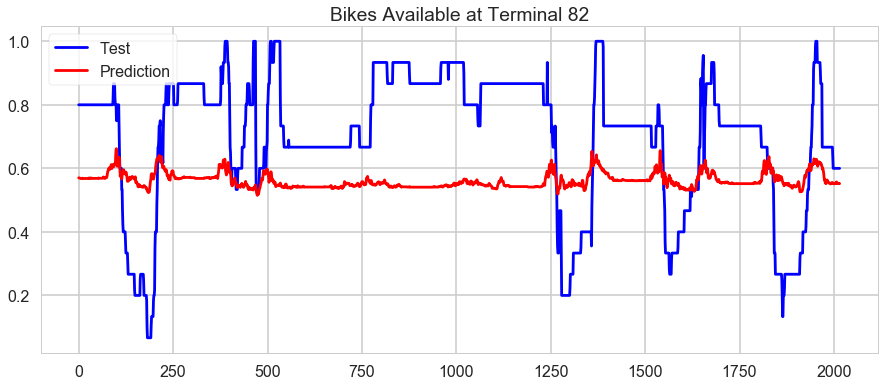

          t-1       t+1
t-1  1.000000  0.996348
t+1  0.996348  1.000000

Test MSE: 0.0553


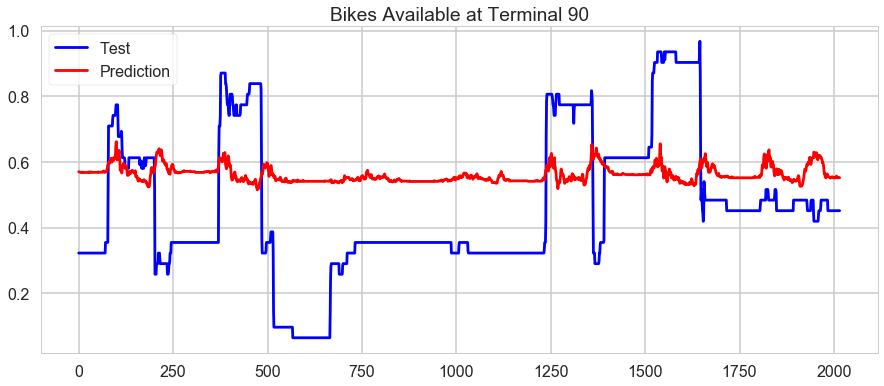

          t-1       t+1
t-1  1.000000  0.996308
t+1  0.996308  1.000000

Test MSE: 0.1043


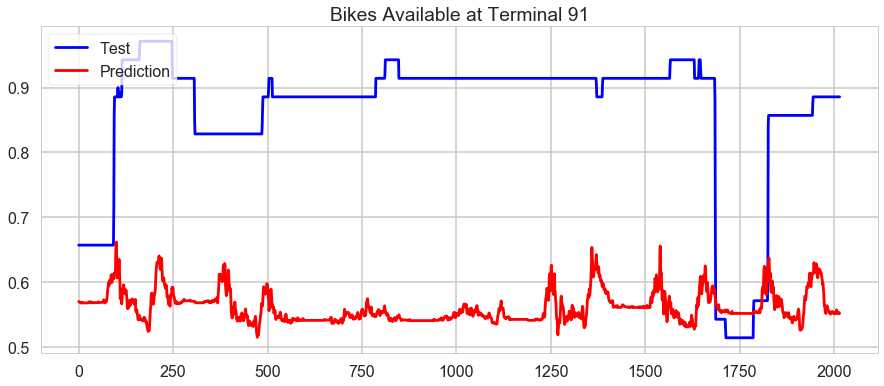

In [25]:
mse_dict = {}

for station in sorted(pd.unique(status_df.station_id)):
    try:
                
        df = status_df[status_df.station_id == station]
        
        util = df['utilization'].copy()
        
        values = pd.DataFrame(util.values)
        df = pd.concat([values.shift(1), values], axis=1)
        df.columns = ['t-1', 't+1']
        result = df.corr()
        print(result)

        X_station = df.values
        train_station, test_station = X_station[1:-predict_size], X_station[-predict_size:]

        X_station_train, y_station_train = train_station[:,0], train_station[:,1]
        X_station_test, y_station_test = test_station[:,0], test_station[:,1]

        test_score_station = mean_squared_error(y_station_test, y_pred)
        print('\nTest MSE: {:2.4f}'.format(test_score_station))
        
#         sid = 'station_%d' % station
        mse_dict[station] = test_score_station

        plt.subplots(figsize=(15,6))
        plt.plot(y_station_test, c='b', label='Test')
        plt.plot(y_pred, c='r', label='Prediction')
        title = 'Bikes Available at Terminal %d' % station
        plt.title(title)
        
        plt.legend(loc=2, frameon=True)
        
        plt.show()
    except:
        print('Something went wrong with Station %d' % station)

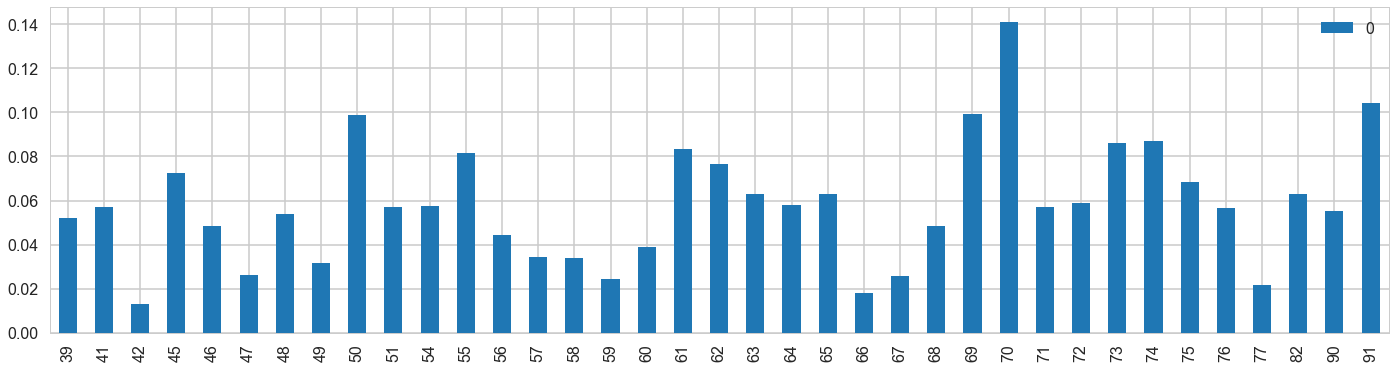

In [26]:
mse_df = pd.Series(mse_dict).to_frame()

mse_df.plot(kind='bar', figsize=(24,6))
plt.show()